# sub_tint = 1s, noise_percentage = 0.001%, matrix_noise = 0

Normalized inverted_s_in: [ 1.00000000e+00  9.99940677e-03 -4.93073428e-08]
Normalized inverted_s_in: [ 1.00000000e+00  9.99777925e-03 -6.92957093e-08]
Normalized inverted_s_in: [1.00000000e+00 9.99533530e-03 8.30198745e-08]
Normalized inverted_s_in: [1.00000000e+00 9.99227193e-03 4.96467185e-07]
Normalized inverted_s_in: [1.00000000e+00 9.98876161e-03 1.21847944e-06]
Normalized inverted_s_in: [1.00000000e+00 9.98495128e-03 2.26594943e-06]
Normalized inverted_s_in: [1.00000000e+00 9.98096310e-03 3.63410757e-06]
Normalized inverted_s_in: [1.00000000e+00 9.97689643e-03 5.30354632e-06]
Normalized inverted_s_in: [1.00000000e+00 9.97283021e-03 7.24561954e-06]
Normalized inverted_s_in: [1.00000000e+00 9.96882567e-03 9.42648124e-06]
Normalized inverted_s_in: [1.00000000e+00 9.96492892e-03 1.18100238e-05]
Normalized inverted_s_in: [1.00000000e+00 9.96117347e-03 1.43599502e-05]
Normalized inverted_s_in: [1.00000000e+00 9.95758237e-03 1.70411801e-05]
Normalized inverted_s_in: [1.00000000e+00 9.9

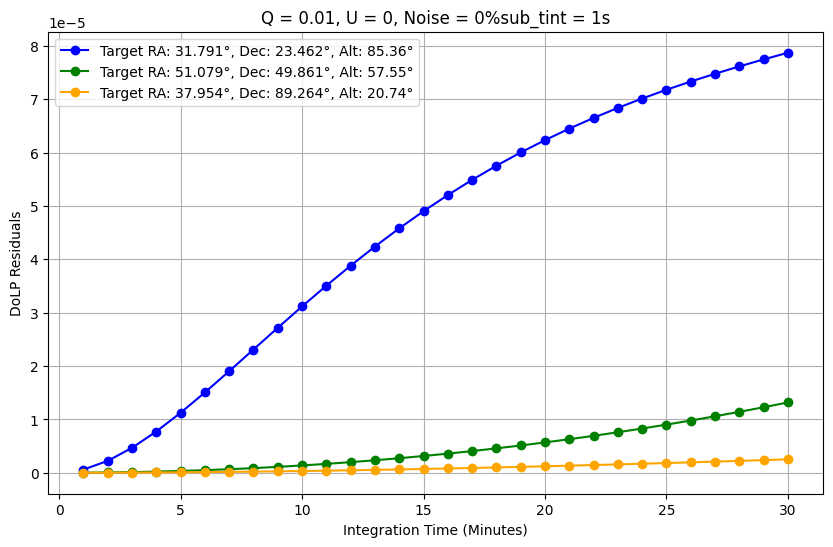

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../../python/')
import angles
import instrument_mm
import stokes

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    {"ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    {"ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST

# Time intervals in seconds (1 to 10 minutes in 1-minute increments)
sub_tint = 1 # given in seconds
time_intervals = np.arange(1, 31) * 60  # Convert minutes to seconds
Q_injected = 0.01  # Example injected polarization level in Stokes Q
U_injected = 0
noise_percentage = 0

# Colors for each target
colors = ['blue', 'green', 'orange']

# Plot data storage
polarization_differences = {i: [] for i in range(len(targets))}

# Run the simulation for each target and each time interval
for target_idx, target in enumerate(targets):
    injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
    
    for t_int in time_intervals:
        # Run matrix inversion function with dynamic PA and altitude, using sub_tint = 1 second
        S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
            ra=target["ra"], 
            dec=target["dec"], 
            observer_latitude=observer_latitude, 
            observer_longitude=observer_longitude, 
            jd_str=observation_date, 
            ut_start=observation_time, 
            t_int=t_int, 
            Q=Q_injected, 
            U=U_injected, 
            delta_HWP=0.5,
            noise_percentage=noise_percentage,
            include_V=False,
            sub_tint=sub_tint,
            normalize_s_out = True  # Sub-integration time in seconds
        )
        
        # Calculate retrieved polarization
        Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
        retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
        
        # Absolute difference in polarization percentage
        abs_diff_polarization = np.abs(injected_polarization - retrieved_polarization)
        polarization_differences[target_idx].append(abs_diff_polarization)

# Plotting the results
plt.figure(figsize=(10, 6))
for target_idx, target in enumerate(targets):
    altitude = angles.calculate_altitude(
        phi=observer_latitude, 
        delta=target["dec"], 
        H=angles.calculate_hour_angle(
            ra=target["ra"], 
            observer_longitude=observer_longitude, 
            ut=observation_time, 
            jd_str=observation_date
        )
    )
    plt.plot(time_intervals / 60, polarization_differences[target_idx], '-o', color=colors[target_idx],
             label=f'Target RA: {target["ra"]}°, Dec: {target["dec"]}°, Alt: {altitude:.2f}°')

# Plot settings
plt.xlabel('Integration Time (Minutes)')
plt.ylabel('DoLP Residuals')
plt.title("Q = " \
    + str(Q_injected) + ", U = " + str(U_injected) + ", Noise = " + \
    str(noise_percentage) + str("%") + "sub_tint = " + str(sub_tint) + "s")
plt.legend()
plt.grid(True)
plt.show()


In [2]:
import os
notebook_name = os.path.splitext(os.path.basename(__file__))[0] if '__file__' in globals() else 'on_sky_angle_changes'
output_dir = "/home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, notebook_name + ".txt")

with open(output_path, "w") as f:
    f.write("Integration Time (min), DoLP Residual, Target RA, Target Dec, Target Altitude\n")
    for target_idx, target in enumerate(targets):
        altitude = angles.calculate_altitude(
            phi=observer_latitude,
            delta=target["dec"],
            H=angles.calculate_hour_angle(
                ra=target["ra"],
                observer_longitude=observer_longitude,
                ut=observation_time,
                jd_str=observation_date
            )
        )
        for t_idx, t_int in enumerate(time_intervals):
            t_min = t_int / 60
            dolp_residual = polarization_differences[target_idx][t_idx]
            f.write(f"{t_min:.2f}, {dolp_residual:.8f}, {target['ra']}, {target['dec']}, {altitude:.2f}\n")
print(f"Saved plot data to {output_path}")

Saved plot data to /home/rebeccaz/Github/modhis_polarimetry_feasibility_study/results/numpy_files/on_sky_angle_changes.txt
